In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math


In [3]:
!pip install st-dbscan
from st_dbscan import ST_DBSCAN
!pip install geopy
import geopy.distance

In [15]:
df_fix = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/bdd.csv")

In [5]:
def convert_time_to_timestamps(df):
    df['TIME_EVENT'] = pd.to_datetime(df['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
    df['TIME_EVENT'] = df.TIME_EVENT.values.astype(np.float64) # in nanoseconds
    df.TIME_EVENT = df.TIME_EVENT / (10 ** 9) # in seconds 
    df.TIME_EVENT = df.TIME_EVENT / 3600 # in hours
    return df

In [6]:
def getting_ready(df, country, year_since):
    df = convert_time_to_timestamps(df)
    df = df[df['COUNTRY'] == country]
    df = df[df['YEAR'] >= year_since]
    df = df[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
    df = df.reset_index(drop=True)
    return df 

In [7]:
def run_dbscan_retrieve_classes(df, spatial_th, time_th, min_sample):
    model = ST_DBSCAN(eps1=spatial_th, eps2=time_th, min_samples=min_sample)
    fit = model.fit(df) 
    labels = pd.DataFrame(model.labels)
    df['LABELS'] = labels
    return df

Visualising the timing of reports with an intensity map 

In [8]:
def visualise_biggest(df, n_biggest):

    nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
    nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
    labels_biggest_storms = list(nb_reports.iloc[0:3,1])
    df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]

    # plots the n_biggest storms 
    plt.figure(figsize=(10,6))
    for i in range(n_biggest):
        a = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        b = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        lab = df_biggest.loc[df_biggest.LABELS == labels_biggest_storms[i]]
        plt.scatter(a, b, c='C{}'.format(i), label='{} most reported storm'.format(i+1))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.legend()
    plt.title("The {} biggest storms in terms of report counts".format(len(labels_biggest_storms)))
    plt.show()

    # plot timing of storms in latlon
    for i in range(n_biggest):
        x = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        y = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        z = df_biggest.TIME_EVENT[df_biggest.LABELS == labels_biggest_storms[i]]
        z = z - z.iloc[-1]
        x = x.array
        y = y.array
        z = z.array
        axis = plt.subplot(111, title="Storm with {} reports".format(len(x)))
        sc = axis.scatter(x, y, c=z, marker=".")
        plt.colorbar(sc, label="duration of the storm (in hours)")
        plt.show()
        # distance between first and last reports
        df_distance = df_biggest[df_biggest.LABELS==labels_biggest_storms[i]].sort_values('TIME_EVENT')
        df_distance = df_distance.reset_index(drop=True)
        latbegin = df_distance.LATITUDE[0]
        latend = df_distance.LATITUDE[len(df_distance.LATITUDE)-1]
        lonbegin = df_distance.LONGITUDE[0]
        lonend = df_distance.LONGITUDE[len(df_distance.LONGITUDE)-1]
        coords_1 = (latbegin, lonbegin)
        coords_2 = (latend, lonend)
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        print("The storm has length",dist,"km between first report and last report")


    return df

In [9]:
df = df_fix.copy()
country = 'FR'
year_since = 2022
df = getting_ready(df, country, year_since)
df

,TIME_EVENT,LATITUDE,LONGITUDE
0,462946.250000,45.567,5.933
1,462945.866667,45.596,5.875
2,462928.500000,49.583,1.358
3,462928.416667,49.533,1.267
4,462928.383333,49.521,1.251
...,...,...,...
1975,458531.666667,43.279,2.460
1976,458514.500000,44.600,-0.933
1977,458174.283333,48.669,5.114
1978,458174.166667,48.636,4.952


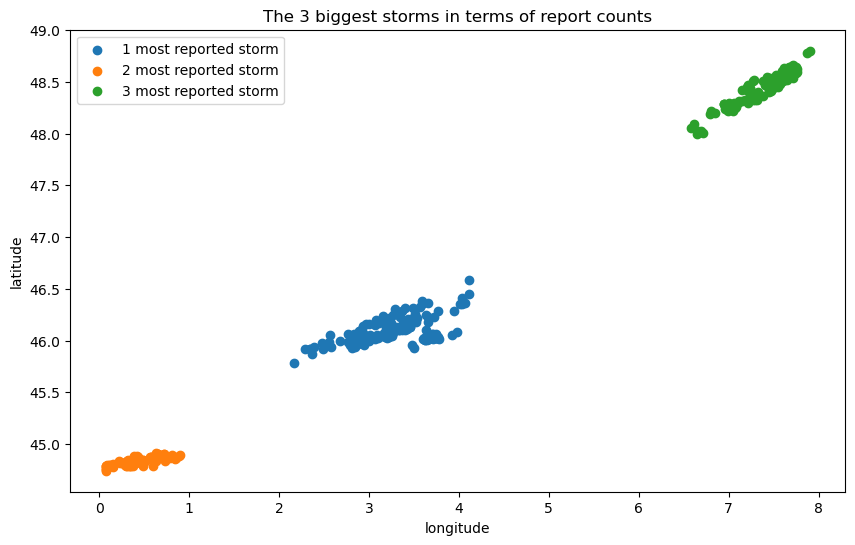

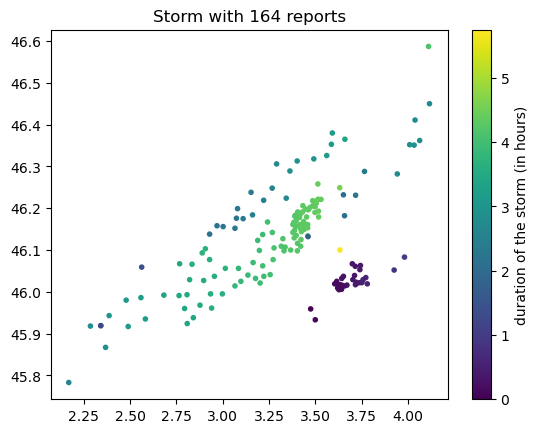

The storm has length 19.88122542533855 km between first report and last report


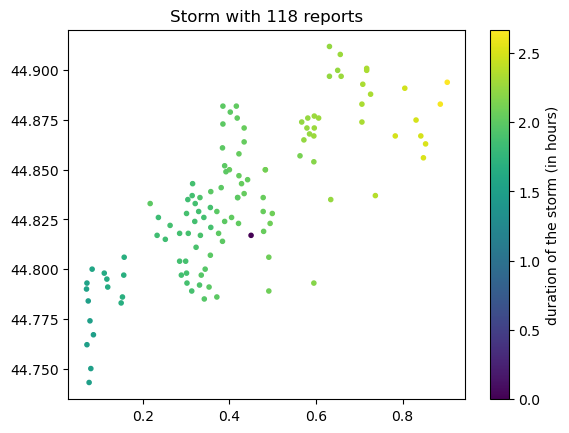

The storm has length 36.81546134117144 km between first report and last report


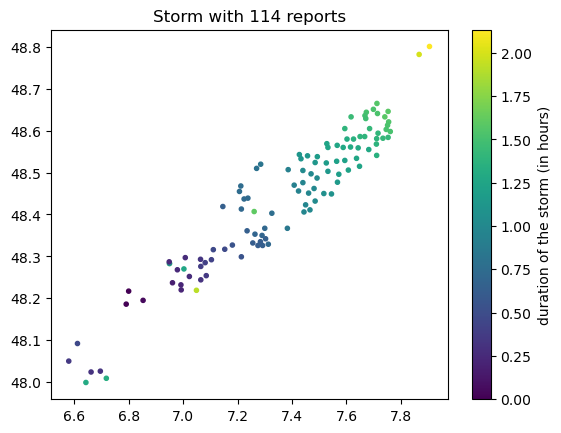

The storm has length 104.32207762462274 km between first report and last report


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,158
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,159
1978,458174.166667,48.636,4.952,159


In [10]:
df1 = run_dbscan_retrieve_classes(df, 0.2, 2, 2)
visualise_biggest(df1,3)

In [11]:
#varying spatial threshold
#for i in np.arange(0.01,0.3,0.03):
#    visualise_biggest(run_dbscan_retrieve_classes(df, i, 2, 2),3)
#    print("Spatial threshold is",i)



donnees demog

In [17]:
database = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/eswd_reports_europe_1970_2022.csv")

C:\Users\t480\AppData\Local\Temp\ipykernel_22392\3418599384.py:1: DtypeWarning: Columns (18,22,23,24,50,51,77,78,79,85,88) have mixed types. Specify dtype option on import or set low_memory=False.
  database = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/eswd_reports_europe_1970_2022.csv")


In [33]:
data_demog = pd.read_excel("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/data demog.xlsx")

In [16]:
df_fix

,Unnamed: 0,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR
0,0,45.567,5.933,2022-10-24 10:15:00,FR,2022
1,1,45.596,5.875,2022-10-24 09:52:00,FR,2022
2,2,50.967,2.667,2022-10-23 17:00:00,BE,2022
3,3,51.000,2.700,2022-10-23 17:00:00,BE,2022
4,4,49.583,1.358,2022-10-23 16:30:00,FR,2022
...,...,...,...,...,...,...
43607,43607,48.750,7.100,2007-02-11 15:10:00,FR,2007
43608,43608,52.150,14.650,2007-01-18 19:00:00,DE,2007
43609,43609,52.083,10.333,2007-01-18 17:10:00,DE,2007
43610,43610,43.600,39.730,2007-01-16 02:00:00,RU,2007


In [27]:
database.columns


Index(['ID', 'QC_LEVEL', 'INFO_SOURCE', 'CONTACT', 'EMAIL', 'ORGANISATION',
       'ORGANISATION_ID', 'NO_REVISION', 'PERSON_REVISION', 'TIME_EVENT',
       'TIME_CREATION', 'TIME_LAST_REVISION', 'TIME_ACCURACY', 'COUNTRY',
       'STATE', 'PLACE', 'PLACE_LOCAL_LANGUAGE', 'DETAILED_LOCATION',
       'NEAREST_CITY', 'LATITUDE', 'LONGITUDE', 'PLACE_ACCURACY', 'OROGRAPHY',
       'SURFACE_INITIAL_LOCATION', 'SURFACE_CROSSED', 'TYPE_EVENT',
       'NO_OBJECTS', 'MAX_HAIL_DIAMETER', 'MAX_HAILSTONE_WEIGHT',
       'AVERAGE_HAIL_DIAMETER', 'THICKNESS_HAIL_LAYER', 'HAILSTONE', 'F_SCALE',
       'T_SCALE', 'RATING_BASIS', 'WIND_SPEED', 'TEN_MIN_WIND_SPEED',
       'FUNNEL_SIGHTED', 'SUCTION_VORTICES', 'PRECIPITATION_AMOUNT',
       'SNOW_FALL_AMOUNT', 'PEAK_PRECIP_AMOUNT', 'PEAK_SNOW_FALL_AMOUNT',
       'PEAK_PRECIP_PERIOD', 'MAX_6_HOUR_PRECIP', 'MAX_6_HOUR_SNOW_FALL',
       'MAX_12_HOUR_PRECIP', 'MAX_12_HOUR_SNOW_FALL', 'MAX_24_HOUR_PRECIP',
       'MAX_24_HOUR_SNOW_FALL', 'CONVECTIVE', 'TOT

In [30]:
database.columns
geo = database[["STATE", 'PLACE', 'DETAILED_LOCATION','NEAREST_CITY', 'COUNTRY']]
geo = geo[geo['COUNTRY'] == 'FR']
geo

,STATE,PLACE,DETAILED_LOCATION,NEAREST_CITY,COUNTRY
0,Région Rhône-Alpes,Chambéry,NaN,NaN,FR
1,Région Rhône-Alpes,La Motte-Servolex,NaN,NaN,FR
4,Région Haute-Normandie,Buchy,NaN,NaN,FR
5,Région Haute-Normandie,Bierville,NaN,NaN,FR
6,Région Haute-Normandie,Morgny-la-Pommeraye,NaN,NaN,FR
...,...,...,...,...,...
48369,Région Poitou-Charentes,Saint-Hilaire-la-Palud,NaN,NaN,FR
48375,Région Centre,Montargis,NaN,NaN,FR
48376,Région Centre,Villemurlin,NaN,NaN,FR
48377,Région Centre,Villequiers,NaN,NaN,FR


In [35]:
data_demog = data_demog.rename(columns = {'Insee - Statistiques locales':'POSTCODE', 'Unnamed: 1':'PLACE', 'Unnamed: 2':'POPULATION'})
data_demog = data_demog.iloc[3:-1]

In [2]:
# cannot merge our data with data from insee since there is a lot of cities that will not have a track.
# we need the latitude and longitude of each cities in the insee data
# need to study the shape of storms, if it is a rectangle, that is rather straight, 
# with some depending thickness, then we can start to infer movements
# say we have two clusters and they are in a rectangle, but in the middle there is no track
# then it may be the same storm. 
# we can compute an average reporting rate, then multiply with the population in the cities where no tracks appear
# if this expected number of reports is lower than a threshold, it may be the two clusters 
# represent only one storm
# we also need to inspect a few KM ahead and after the cluster, whether or not another cluster may be related 
# this is to observe formation and death of each storm, that may be less intense zones but still 
# important to study : time to reach peak activity for example

We want to investigate whether we miss-detect the area of the storm because some regions are not populated 

compute rate of report 

In [ ]:
# idea of algorithm 
# we run dbscan with restrictive parameters,
# then for each cluster, we take the cities in the rectangle and we compute their expected nb of reports 
# if the figure is above the threshold we keep it as is
# but if it is below, we run dbscan with less restrictive parameters on a subset of obs
# in particular we delete all observations not in the trajectory 
# (the rectangle, with an arbitrarily big length and width) and that are not timely coherent 
